# Introduction to Sentiment Classification techniques with scikit-learn, keras and tensorflow

[Project requirements](https://review.udacity.com/#!/rubrics/1507/view)

### Selection of an Data Set to implement sentiment classification techniques

After searching for some text classification Open Data Sets detailed below, I finaly chose a [data set available on Kaggle (https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

- [Open Data Sets for text classification](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

- [IMBD DataSet for Movies Reviews](http://ai.stanford.edu/~amaas/data/sentiment/)

- [BBC text categorization](https://www.kaggle.com/yufengdev/bbc-text-categorization)

- [Sentiment Analysis in Finance](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

### Usefull links when writing this medium post:
- Links on medium posts best practices :
    - [Get Started with medium](https://blog.hubspot.com/marketing/how-to-use-medium)
    - [Tips for medium writer](https://blog.medium.com/tips-and-tricks-for-medium-writers-1d79498101c3)
- Links on Data Science posts regarding text classification techniques :
    - https://towardsdatascience.com/basic-binary-sentiment-analysis-using-nltk-c94ba17ae386
    - https://medium.com/analytics-vidhya/how-to-succeed-in-multilingual-sentiment-analysis-without-transformers-f1a98c76c30c
    - https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2

### Import Usefull Packages

In [48]:
# Classic Python Package
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [62]:
from wordcloud import WordCloud,STOPWORDS

In [3]:
# Text feature engineering related packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords,wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import re

[nltk_data] Downloading package punkt to /Users/boubou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/boubou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/boubou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/boubou/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# Scikit learn useful packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report,fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

In [128]:
# Import Deep Learning packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Input,LSTM,Embedding,Activation
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import to_categorical

# I. Data Exploration of the financial news headlines, and first feature engineering

In [49]:
# Load Data
data = pd.read_csv('Data/all-data.csv',encoding='latin-1', names=['sentiment', 'text'])
print(data.shape)
data.head()

(4846, 2)


,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [7]:
data.text.iloc[0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

neutral     0.594098
positive    0.281263
negative    0.124639
Name: sentiment, dtype: float64


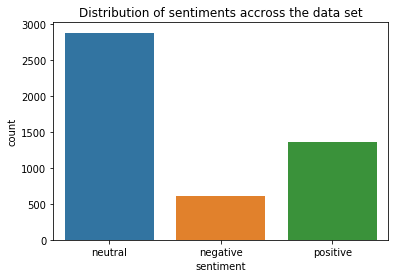

In [50]:
sns.countplot(x='sentiment', data=data).set_title("Distribution of sentiments accross the data set")
print(data.sentiment.value_counts()/data.shape[0])

## Feature Enginnering 

In [9]:
## Remove sentiment expression for the stop words
#stopwords.words("english")
#stopwords_to_keep = ['']

In [10]:
def tokenize(text,part_of_speech=False):
    '''
    Tokenize the text sentence
    Input:
        - text: (str): one financial review sentence
        - part_of_speech (Boolean): if true implement part of speech tagging and select the words you want to keep (["J","R","V"]) 
    Ouput:
    - clean_tokens (list): list of tokenized string text elements
    '''
    
    # Normalise by setting to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    # Create tokens 
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    #tokens = [w for w in tokens]
    
    # Part of speech tagging : https://pythonprogramming.net/part-of-speech-tagging-nltk-tutorial/
    if part_of_speech == True :
        all_words =[]
        pos = nltk.pos_tag(tokens)
        allowed_word_types = ["J","R","V","N"]
        for w in pos:
            if w[1][0] in allowed_word_types:
                all_words.append(w[0].lower())
        
    
    # Lemmatise words
    clean_tokens = [WordNetLemmatizer().lemmatize(w) for w in tokens]

    return clean_tokens

In [53]:
data["token_text"] = data["text"].apply(lambda x: tokenize(x))

In [54]:
data["token_text_pos"] = data["text"].apply(lambda x: tokenize(x,part_of_speech=True))

In [55]:
data.text.iloc[0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

In [56]:
data.token_text.iloc[0]

['according',
 'gran',
 'company',
 'plan',
 'move',
 'production',
 'russia',
 'although',
 'company',
 'growing']

# II. Machine learning approach for sentiment classification

In [210]:
# Split train and test sets
x_train,x_test,y_train,y_test = train_test_split(data.text,data.sentiment,test_size = 0.2 , random_state = 0)

In [15]:
# Check that the class are in same proportion in both train and test set
print(y_train.value_counts()/len(y_train))

print(y_test.value_counts()/len(y_test))

neutral     0.594427
positive    0.282766
negative    0.122807
Name: sentiment, dtype: float64
neutral     0.592784
positive    0.275258
negative    0.131959
Name: sentiment, dtype: float64


## Data Vizualisation

In [16]:
pos = x_train[y_train[y_train=='positive'].index]
pos[0:5]

1185    Atria will launch a campaign in September to p...
1888    `` We are pleased to welcome Tapeks Noma into ...
581     The contract was signed in August with Papua N...
12      A purchase agreement for 7,200 tons of gasolin...
2027    Loss after taxes amounted to EUR 1.2 mn compar...
Name: text, dtype: object

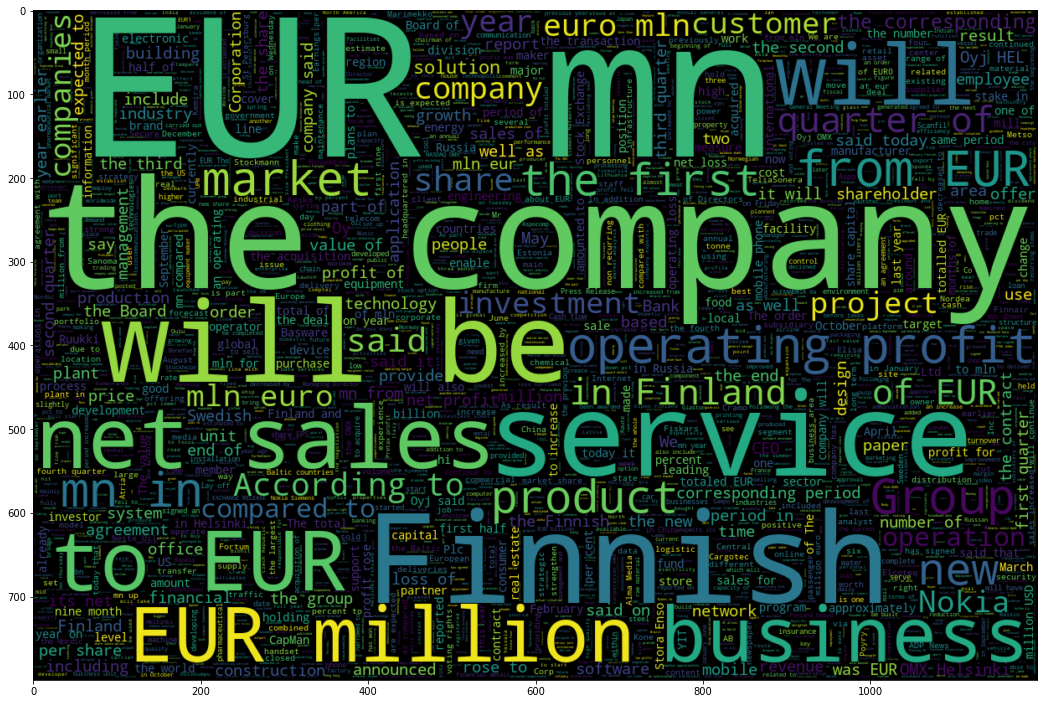

In [64]:
plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
wordcloud = WordCloud(min_font_size = 3,stopwords = STOPWORDS, max_words = 2500 , width = 1200 , height = 800).generate(" ".join(x_train))
plt.imshow(wordcloud,interpolation = 'bilinear')

## Standard Approach: using sklearn Tfidf transformer and a classification 

### - Baseline model

In [222]:
baseline = ["neutral"]*len(y_test)
y_pred_test = pd.Series(baseline)

# Print the classification report 
print(classification_report(y_test, y_pred_test, target_names=["neutral","positive","negative"]))

              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       128
    positive       0.59      1.00      0.74       575
    negative       0.00      0.00      0.00       267

    accuracy                           0.59       970
   macro avg       0.20      0.33      0.25       970
weighted avg       0.35      0.59      0.44       970



### - Test different classification models

In [168]:
def make_prediction_with_pipeline(model):
    '''
    Take a model, build the associated pipeline and evaluate its performance on the test set
    Input: 
    - model (sklearn model) : model to be tested
    Output:
    - Confusion Matrix (array): matrix array with true and predicted labels
    - basic_pipeline (sklearn object): fitted pipeline object
    '''
    
    # Build the pipeline
    basic_pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', model)
    ])
    
    # Fit the pipeline
    basic_pipeline.fit(x_train,y_train)
    basic_start_time = time.time()
    basic_pipeline.fit(x_train,y_train)
    basic_end_time = time.time() - basic_start_time
    print("the training lasts for {} minutes".format(basic_end_time/60))
    
    # Make prediction
    y_pred_test = basic_pipeline.predict(x_test)
    
    # Print the classification report 
    print(classification_report(y_test, y_pred_test, target_names=["neutral","positive","negative"]))
    
    # Plot the confusion matrix
       disp = plot_confusion_matrix(basic_pipeline, x_test, y_test,
                                     display_labels=["neutral","positive","negative"],
                                     cmap=plt.cm.Blues)
    disp.ax_.set_title("Confusion Matrix")
    print("Confusion Matrix")
    print(disp.confusion_matrix)
    
    return disp.confusion_matrix,basic_pipeline

the training lasts for 0.06453466415405273 minutes
              precision    recall  f1-score   support

     neutral       0.85      0.41      0.55       128
    positive       0.75      0.94      0.84       575
    negative       0.76      0.53      0.63       267

    accuracy                           0.76       970
   macro avg       0.79      0.63      0.67       970
weighted avg       0.77      0.76      0.74       970

Confusion Matrix
[[ 52  60  16]
 [  4 543  28]
 [  5 120 142]]


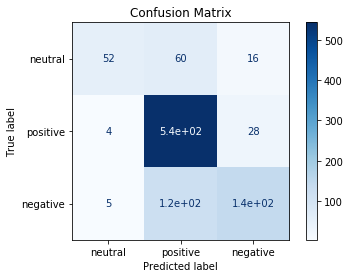

In [169]:
# Logistic regression
_, pipeline_fitted= make_prediction_with_pipeline(LogisticRegression(random_state=42))

the training lasts for 0.5438359618186951 minutes


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       128
    positive       0.69      0.98      0.81       575
    negative       0.65      0.36      0.46       267

    accuracy                           0.68       970
   macro avg       0.44      0.45      0.42       970
weighted avg       0.59      0.68      0.61       970

Confusion Matrix
[[  0  87  41]
 [  0 564  11]
 [  0 171  96]]


array([[  0,  87,  41],
       [  0, 564,  11],
       [  0, 171,  96]])

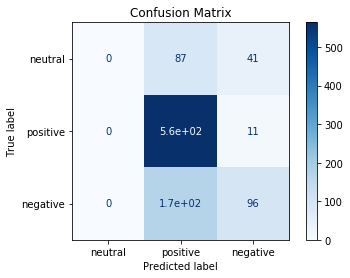

In [102]:
# Naive Bayes Classifier
make_prediction_with_pipeline(MultinomialNB())

the training lasts for 0.6107428789138794 minutes
              precision    recall  f1-score   support

     neutral       0.79      0.32      0.46       128
    positive       0.71      0.97      0.82       575
    negative       0.77      0.40      0.52       267

    accuracy                           0.73       970
   macro avg       0.76      0.56      0.60       970
weighted avg       0.74      0.73      0.69       970

Confusion Matrix
[[ 41  70  17]
 [  3 558  14]
 [  8 153 106]]


array([[ 41,  70,  17],
       [  3, 558,  14],
       [  8, 153, 106]])

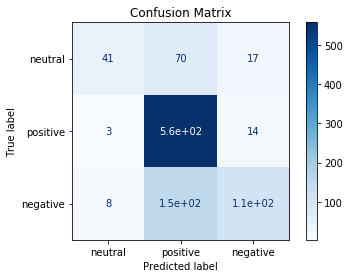

In [103]:
# Support Vector classifier
make_prediction_with_pipeline(SVC(random_state=42))

### - Try improving further one of the classification model

In [135]:
# Try to optimize the performance of the Logistic Regression model
pipeline_fitted.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x1a22baaae8>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'vect': CountVectorizer(analy

In [ ]:
parameters = {'clf__multi_class':['multinomial'],
             #'clf__class_weight': [None, "balanced"],
             'clf__C':np.random.uniform(1,10,4).tolist()}
skfolds = StratifiedKFold(n_splits=3)
gridsearch_pipeline = GridSearchCV(pipeline_fitted, param_grid=parameters, scoring='f1_samples', cv = skfolds)y

# Save the model
model_to_export
joblib.dump(model_to_export, "model.pkl")

# III. More advanced approach leveraging on Deep Learning, Embeddings and RNN

In [17]:
# Prepare output to implement a softmax classifier: one hot encoding
y_train[y_train=='positive']=2
y_train[y_train=='neutral']=1
y_train[y_train=='negative']=0
y_test[y_test=='positive']=2
y_test[y_test=='neutral']=1
y_test[y_test=='negative']=0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_test.shape

((3876, 3), (970, 3))

## 1. Neural network with Keras

In [107]:
# Feature Engineering of training and test data
count_vec = CountVectorizer(max_features=4000, tokenizer=tokenize,max_df=0.9, min_df=0)
x_train_features = count_vec.fit_transform(x_train).todense()
x_test_features = count_vec.transform(x_test).todense()
x_train_features.shape,x_test_features.shape

((3876, 4000), (970, 4000))

In [108]:
tfidf = TfidfTransformer()
pd.DataFrame(tfidf.fit_transform(x_train_features).todense())

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.000000,0.0,0.352811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,0.135893,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3872,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3873,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3874,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
# Function to fit our model and plot accuracy curves for train and test data.

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=x_train_features.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=3,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

start_time = time.time()

history = model.fit(x_train_features, y_train, validation_data=(x_test_features, y_test), epochs=10, verbose=1)
end_time = time.time()-start_time
print(end_time)

#Print('Accuracy with',optimizer,'optimizer is :',model.evaluate(x_test_features, y_test)[1]*100)

Train on 3876 samples, validate on 970 samples
Epoch 1/10
3876/3876 [==============================] - 5s 1ms/sample - loss: 0.8580 - accuracy: 0.6218 - val_loss: 0.6888 - val_accuracy: 0.7144
Epoch 2/10
3876/3876 [==============================] - 3s 832us/sample - loss: 0.5146 - accuracy: 0.8001 - val_loss: 0.6247 - val_accuracy: 0.7526
Epoch 3/10
3876/3876 [==============================] - 3s 897us/sample - loss: 0.2752 - accuracy: 0.9087 - val_loss: 0.6884 - val_accuracy: 0.7361
Epoch 4/10
3876/3876 [==============================] - 3s 823us/sample - loss: 0.1423 - accuracy: 0.9603 - val_loss: 0.7925 - val_accuracy: 0.7371
Epoch 5/10
3876/3876 [==============================] - 3s 810us/sample - loss: 0.0821 - accuracy: 0.9791 - val_loss: 0.9046 - val_accuracy: 0.7402
Epoch 6/10
3876/3876 [==============================] - 4s 929us/sample - loss: 0.0552 - accuracy: 0.9871 - val_loss: 1.0512 - val_accuracy: 0.7320
Epoch 7/10
3876/3876 [==============================] - 3s 837us/sa

Text(0.5, 1.0, 'Adam Optimizer')

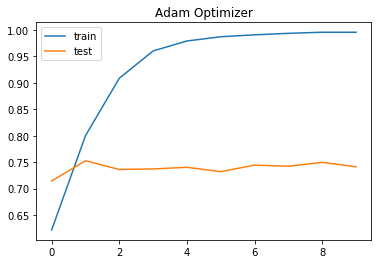

In [110]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Adam Optimizer')

In [111]:
Y_pred = model.predict(x_test_features)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred.shape)
print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))
print(classification_report(np.argmax(y_test,axis=1), y_pred, target_names=["negative","neutral","positive"]))

(970, 3)
(970,)
Confusion Matrix
[[ 74  38  16]
 [ 21 492  62]
 [ 19  95 153]]
              precision    recall  f1-score   support

    negative       0.65      0.58      0.61       128
     neutral       0.79      0.86      0.82       575
    positive       0.66      0.57      0.61       267

    accuracy                           0.74       970
   macro avg       0.70      0.67      0.68       970
weighted avg       0.73      0.74      0.74       970



## 2. Add a pre-trained embedding layer using tensorflow hub

In [113]:
# Transform the data into tensors
X_train = tf.convert_to_tensor(x_train)
Y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(x_test)
Y_test = tf.convert_to_tensor(y_test)

In [81]:
import tensorflow_hub as hub

# Text embedding based on Swivel co-occurrence matrix factorization trained on English Google News 130GB corpus.
#embedding_1= "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
# https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1

# Word2Vec embedding trained on English Wikipedia corpus
embedding_2 = "https://tfhub.dev/google/Wiki-words-250-with-normalization/2"
# https://tfhub.dev/google/Wiki-words-500-with-normalization/2

hub_layer = hub.KerasLayer(embedding_2,input_shape=[],dtype=tf.string, trainable=False)

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/Wiki-words-250-with-normalization/2",
                           input_shape=[],dtype=tf.string, trainable=False)

In [82]:
embed_tensor = hub_layer(X_train[0:2])
print(embed_tensor.shape)
embed_tensor

(2, 250)


<tf.Tensor: id=29606, shape=(2, 250), dtype=float32, numpy=
array([[-1.52712166e-01, -1.36563748e-01,  6.17174804e-02,
        -1.79967463e-01,  9.57933441e-03,  1.34833604e-01,
         8.55822414e-02,  3.22328508e-02, -8.99228174e-03,
         9.56106260e-02, -1.42048433e-01,  2.43408918e-01,
        -1.07511349e-01, -8.88460726e-02,  2.72853911e-01,
         1.24718815e-01,  5.17277606e-02, -1.04414681e-02,
         3.20396312e-02,  1.19814828e-01,  4.25983267e-03,
         1.43762648e-01, -3.05806356e-03,  3.56078031e-03,
         2.82065004e-01, -2.22232006e-02,  1.21303812e-01,
         1.15962960e-01,  1.38368651e-01,  3.33463550e-02,
         1.86627641e-01, -2.51416191e-02,  4.01872918e-02,
        -1.18605852e-01, -8.18438176e-03,  1.11439086e-01,
        -2.04646766e-01, -9.77456346e-02,  2.94724733e-01,
        -1.13033086e-01, -2.16905713e-01,  2.29085043e-01,
        -1.07505610e-02, -4.68661226e-02,  1.74058601e-01,
         1.97038069e-01, -4.18239124e-02, -2.62974381e-

In [97]:
model = Sequential()
model.add(hub_layer)
model.add(Dense(16, activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, verbose=1)

Train on 3876 samples, validate on 970 samples
Epoch 1/20
3876/3876 [==============================] - 3s 737us/sample - loss: 0.9084 - accuracy: 0.5911 - val_loss: 0.8582 - val_accuracy: 0.6320
Epoch 2/20
3876/3876 [==============================] - 1s 372us/sample - loss: 0.8161 - accuracy: 0.6393 - val_loss: 0.8021 - val_accuracy: 0.6515
Epoch 3/20
3876/3876 [==============================] - 1s 295us/sample - loss: 0.7731 - accuracy: 0.6618 - val_loss: 0.7798 - val_accuracy: 0.6402
Epoch 4/20
3876/3876 [==============================] - 1s 275us/sample - loss: 0.7465 - accuracy: 0.6752 - val_loss: 0.7410 - val_accuracy: 0.6856
Epoch 5/20
3876/3876 [==============================] - 1s 253us/sample - loss: 0.7257 - accuracy: 0.6770 - val_loss: 0.7264 - val_accuracy: 0.7021
Epoch 6/20
3876/3876 [==============================] - 1s 231us/sample - loss: 0.7103 - accuracy: 0.6886 - val_loss: 0.7135 - val_accuracy: 0.6990
Epoch 7/20
3876/3876 [==============================] - 1s 246us/

Text(0.5, 1.0, 'Adam Optimizer')

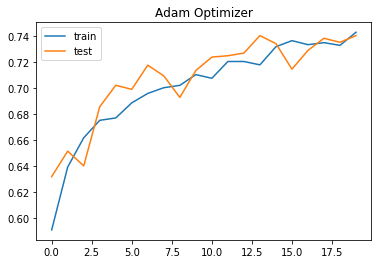

In [98]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Adam Optimizer')

In [103]:
Y_pred = model.predict(X_test)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred.shape)
print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))
print(classification_report(np.argmax(y_test,axis=1), y_pred, target_names=["negative","neutral","positive"]))

(970, 3)
(970,)
Confusion Matrix
[[ 66  44  18]
 [ 22 509  44]
 [ 28  96 143]]
              precision    recall  f1-score   support

    negative       0.57      0.52      0.54       128
     neutral       0.78      0.89      0.83       575
    positive       0.70      0.54      0.61       267

    accuracy                           0.74       970
   macro avg       0.68      0.65      0.66       970
weighted avg       0.73      0.74      0.73       970



In [33]:
# Male prediction
print(x_test.iloc[0:5].values)
model.predict(x_test.iloc[0:5])

['The Bristol Port Company has sealed a one million pound contract with Cooper Specialised Handling to supply it with four 45-tonne , customised reach stackers from Konecranes .'
 'A paper mill in the central Maine town of Madison soon will have a new owner .'
 'ALEXANDRIA , Va. , Oct. 23 -- Hans-Otto Scheck of Espoo , Finland , has developed a method of identifying remote radio units in a communication system .'
 'Altona stated that the private company of Altona chairman Kevin Maloney , Tulla Resources , would take up its entitlement in full .'
 'Registration is required .']


array([[ 1.5843537 ,  2.3143415 ,  1.050876  ],
       [ 0.5912608 ,  1.5891019 ,  1.2467544 ],
       [-0.83255625,  2.3957481 ,  1.1728902 ],
       [-0.468301  ,  1.1446182 ,  0.48532867],
       [-1.1893461 ,  0.68368936,  1.2096647 ]], dtype=float32)

## 4. Combine LSTM with pre-trained Embeddings - WIP

<img src="LSTM.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 1**: A 2-layer LSTM sentiment classifier. </center></caption>

In [118]:
maxLen = len(max(x_train, key=len).split())
print(maxLen)

81


In [119]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [121]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B/glove.6B.50d.txt')

In [177]:
# GRADED FUNCTION: sentences_to_indices

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word_to_index.keys():
                X_indices[i, j] = word_to_index[w]
            else:
                X_indices[i, j]=0
            # Increment j to j + 1
            j += 1
            
    ### END CODE HERE ###
    
    return X_indices

In [178]:
# GRADED FUNCTION: pretrained_embedding_layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it non-trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [179]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

In [185]:
sentence_indices = Input(maxLen, dtype = 'int32')

# Create the embedding layer pretrained with GloVe Vectors (≈1 line)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

# Propagate sentence_indices through your embedding layer, you get back the embeddings
embeddings = embedding_layer(sentence_indices)   

# Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
# Be careful, the returned output should be a batch of sequences.
X = LSTM(128, return_sequences = True)(embeddings)
# Add dropout with a probability of 0.5
X = Dropout(0.5)(X)
# Propagate X trough another LSTM layer with 128-dimensional hidden state
# Be careful, the returned output should be a single hidden state, not a batch of sequences.
X = LSTM(128, return_sequences = False)(X)
# Add dropout with a probability of 0.5
X = Dropout(0.5)(X)
# Propagate X through a Dense layer with softmax activation to get back a batch of 3-dimensional vectors.
X = Dense(3)(X)
# Add a softmax activation
X = Activation('softmax')(X)

# Create Model instance which converts sentence_indices into X.
model = Model(inputs = sentence_indices, outputs = X)

In [186]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 81)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 81, 50)            20000050  
_________________________________________________________________
lstm_8 (LSTM)                (None, 81, 128)           91648     
_________________________________________________________________
dropout_18 (Dropout)         (None, 81, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 387 

In [187]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [193]:
X_train_indices = sentences_to_indices(np.array(x_train), word_to_index, max_len = maxLen)

In [203]:
start_time = time.time()
history = model.fit(X_train_indices, Y_train, epochs = 50)
end_time = time.time()- start_time

Train on 3876 samples
Epoch 1/50
3876/3876 [==============================] - 85s 22ms/sample - loss: 0.8299 - accuracy: 0.6502
Epoch 2/50
3876/3876 [==============================] - 80s 21ms/sample - loss: 0.8804 - accuracy: 0.6249
Epoch 3/50
3876/3876 [==============================] - 81s 21ms/sample - loss: 0.8801 - accuracy: 0.6143
Epoch 4/50
3876/3876 [==============================] - 84s 22ms/sample - loss: 0.8760 - accuracy: 0.5952
Epoch 5/50
3876/3876 [==============================] - 79s 20ms/sample - loss: 0.8826 - accuracy: 0.6050
Epoch 6/50
3876/3876 [==============================] - 84s 22ms/sample - loss: 0.8524 - accuracy: 0.6388
Epoch 7/50
3876/3876 [==============================] - 69s 18ms/sample - loss: 0.8500 - accuracy: 0.6385
Epoch 8/50
3876/3876 [==============================] - 75s 19ms/sample - loss: 0.8492 - accuracy: 0.6380
Epoch 9/50
3876/3876 [==============================] - 69s 18ms/sample - loss: 0.8482 - accuracy: 0.6404
Epoch 10/50
3876/3876 [=

In [206]:
end_time/60

63.440104417006175

Text(0.5, 1.0, 'Adam Optimizer')

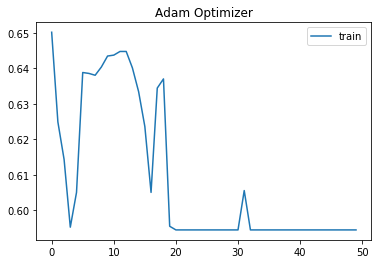

In [208]:
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Adam Optimizer')

In [195]:
Y_pred = model.predict(X_train_indices)

In [197]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [199]:
print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_train,axis=1), y_pred))

Confusion Matrix
[[   0  155  321]
 [   0 2226   78]
 [   0  722  374]]


In [202]:
print(classification_report(np.argmax(y_train,axis=1), y_pred, target_names=["negative","neutral","positive"]))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       476
     neutral       0.72      0.97      0.82      2304
    positive       0.48      0.34      0.40      1096

    accuracy                           0.67      3876
   macro avg       0.40      0.44      0.41      3876
weighted avg       0.56      0.67      0.60      3876



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
